In [ ]:
import os, matplotlib.pyplot as plt, joblib, copy, pandas as pd, pickle
os.environ["OMP_NUM_THREADS"] = "1"
#useful on linux to avoid numpy multithreading

### **Load the trained srnn parameters, filter across repetitions (n), aggreagate across folds (nfold), and sort by aggregated validation_loss**

In [2]:
prepared_data_path = os.path.expanduser('~/data/srnn_data/MPI-ESM')

trained_srnn_parameters_file=os.path.join(prepared_data_path,'trained_srnn_parameters_2a.pkl')
my_list = []
if os.path.isfile(trained_srnn_parameters_file):
    with open(trained_srnn_parameters_file, 'rb') as f:    
        while True:
            try:
                my_list.append(pickle.load(f))
            except EOFError:
                break


df = pd.DataFrame(my_list)
df=df[df['lag']<=30]
df=df[df['m']<=20]
#df=df[df['n']<=30]
print(len(df.to_dict('records')))
# list with a unique entry for each m, lag, nfold, corresponding to minimal validation_loss
df_opt = df.loc[df.groupby(['nfold', 'm', 'lag'])['validation_loss'].idxmin()]
# table with validation loss aggregated across all folds, sorted in ascending order 
df_opt_table=df_opt.pivot(index=['m','lag'], columns=['nfold'], values='validation_loss').dropna().mean(axis=1).sort_values(ascending=True).reset_index()
# print top 10 entries of it
print(df_opt_table.head(10))

109550
    m  lag         0
0  13   13 -0.395117
1  13    9 -0.392317
2  12   10 -0.392076
3  13   11 -0.387911
4  11   13 -0.387250
5  13    8 -0.386628
6  14   11 -0.386583
7  13   12 -0.384989
8  14    7 -0.384611
9  11   12 -0.384469


### **Select optimal m, lag and and save srnn parameters for all folds**

In [3]:
# This is automatic choice based on the of the best validation_loss
# It makes sense to explore the other variants close to top of the table, or detect elbow points in the figures below
m_opt, lag_opt = df_opt_table.iloc[0][['m','lag']]
print(m_opt, lag_opt)
df_selected=df_opt[(df_opt['m']==m_opt) & (df_opt['lag']==lag_opt)]
print(df_selected['validation_loss'])
selected_srnn_parameters_list=df_selected.to_dict('records')

joblib.dump(selected_srnn_parameters_list,'selected_srnn_parameters_list_3a.jpkl')


13.0 13.0
69645    -0.392301
68316    -0.418108
111009   -0.395156
104270   -0.343595
110324   -0.426425
Name: validation_loss, dtype: float64


['selected_srnn_parameters_list_3a.jpkl']

### **Plot more training statistics**

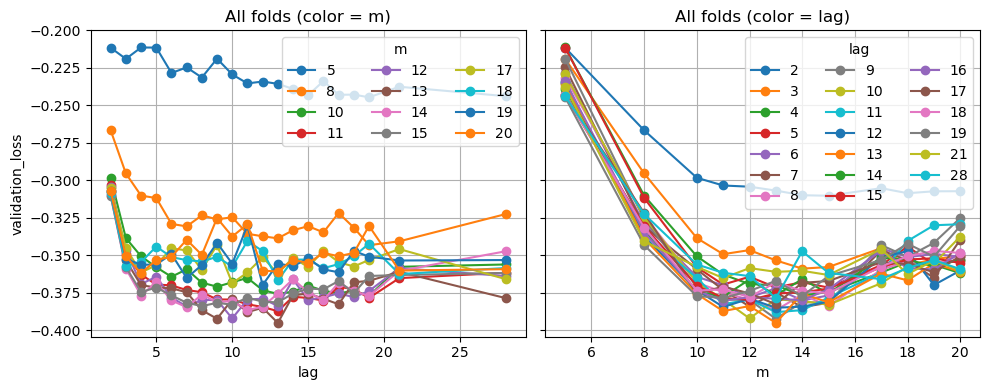

In [4]:
selected_lags = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 28]
selected_m = [5, 8, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

table = df_opt_table.pivot_table(index='m', columns='lag', values=0, aggfunc='min')
table = table.loc[
    [m for m in selected_m if m in table.index],
    [lag for lag in selected_lags if lag in table.columns]
]

# --- Left plot: lines by m ---
table.T.plot(kind='line', marker='o', ax=axs[0], legend=False)
axs[0].set_title('All folds (color = m)')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('validation_loss')
axs[0].grid(True)

# --- Right plot: lines by lag ---
table.plot(kind='line', marker='o', ax=axs[1], legend=False)
axs[1].set_title('All folds (color = lag)')
axs[1].set_xlabel('m')
axs[1].grid(True)

axs[0].set_ylim(top=-0.2)

axs[0].legend(title="m",ncol=3,loc='upper right')
axs[1].legend(title="lag",ncol=3,loc='upper right')

plt.tight_layout()
plt.show()

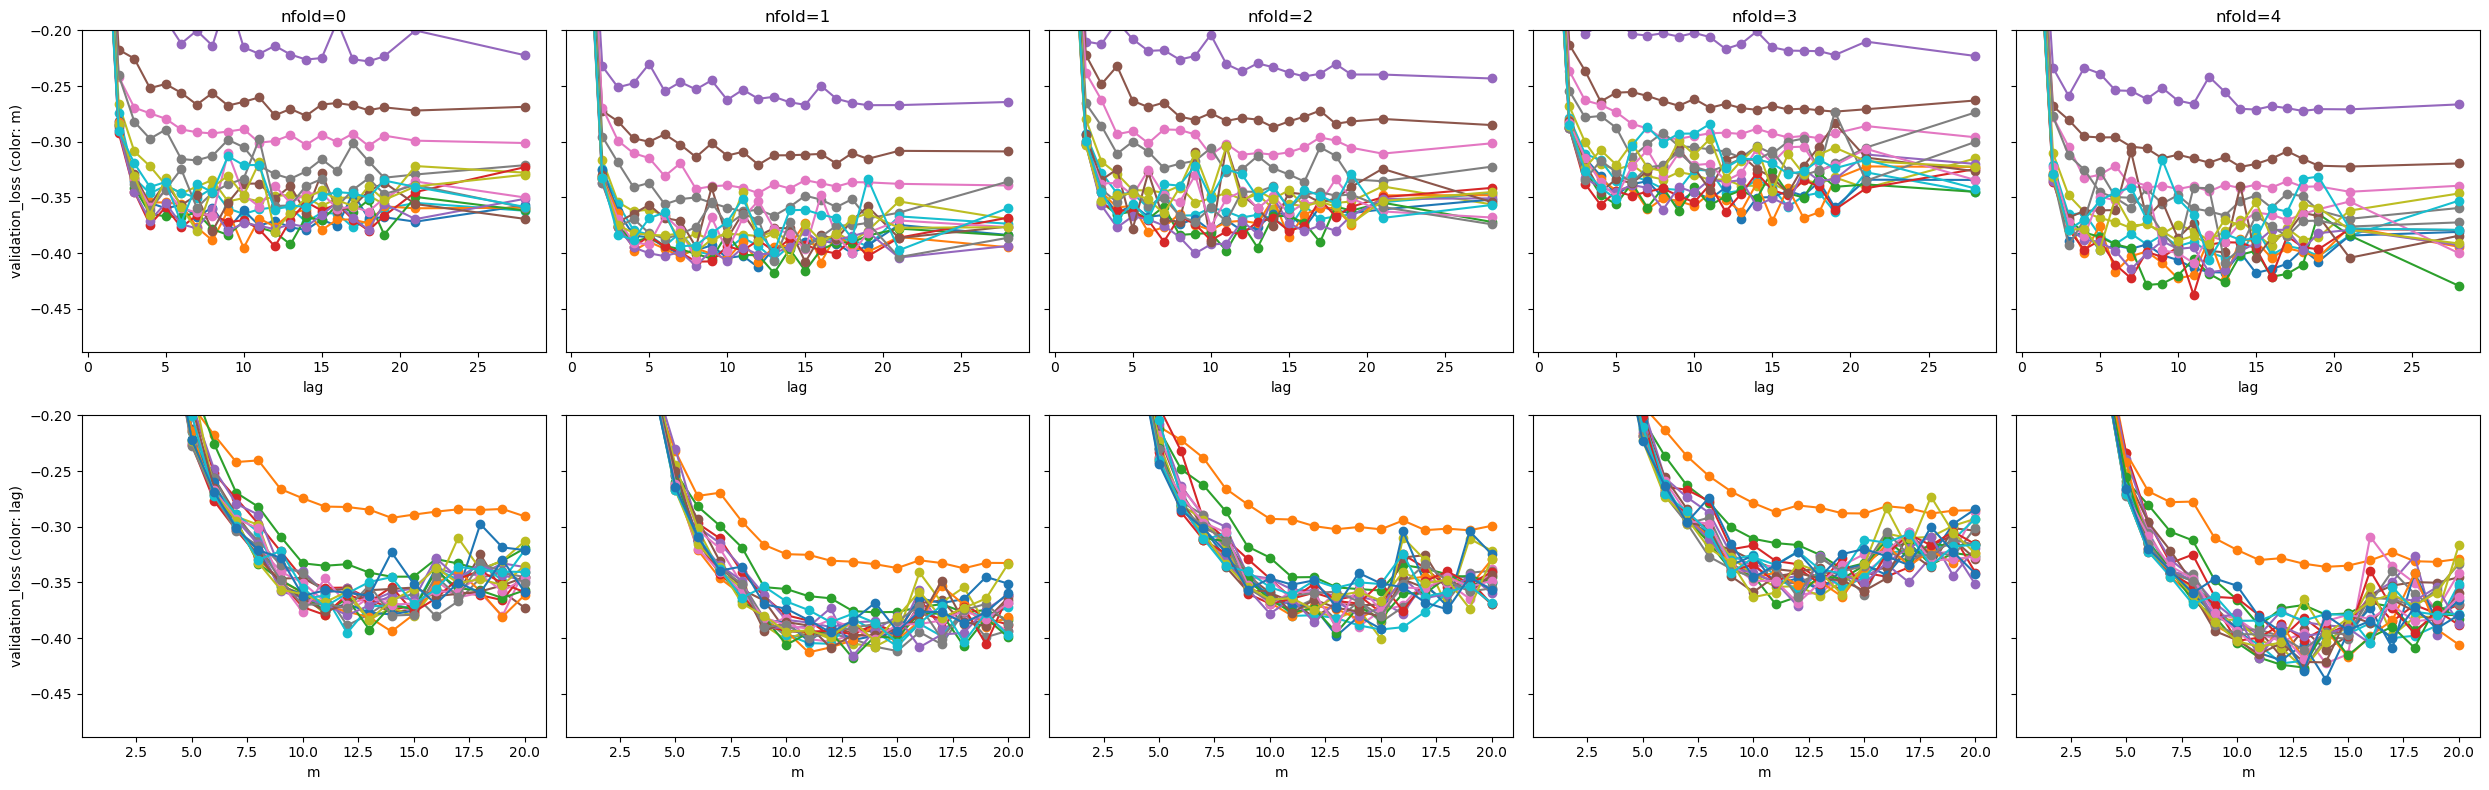

In [5]:
nfolds = df_opt['nfold'].unique()
fig, axs = plt.subplots(2, len(nfolds), figsize=(len(nfolds)*5, 8), sharey=True)

for i, (nfold, g) in enumerate(df_opt.groupby('nfold')):
    table = g.pivot_table(index='m', columns='lag', values='validation_loss', aggfunc='min')
    
    # --- First row: plot lines for each m ---
    table.T.plot(kind='line', marker='o', ax=axs[0, i], legend=False)
    axs[0, i].set_title(f'nfold={nfold}')
    axs[0, i].set_xlabel('lag')
    if i == 0:
        axs[0, i].set_ylabel('validation_loss (color: m)')
    
    # --- Second row: plot lines for each lag ---
    table.plot(kind='line', marker='o', ax=axs[1, i], legend=False)
    axs[1, i].set_xlabel('m')
    if i == 0:
        axs[1, i].set_ylabel('validation_loss (color: lag)')
    
    #axs[0,i].legend(title="m",ncol=3,loc='lower left')
    #axs[1,i].legend(title="lag",ncol=3,loc='lower left') 
axs[0, 0].set_ylim(top=-0.2)
plt.tight_layout()
plt.show()